In [74]:
import pandas as pd
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

### Load data and classifier

In [75]:
TEST_SKIP = True # Test on inchi keys that are not in the training set (True) or not (False). If false then testing is done on unseen data but seen inchi keys.

In [76]:
FINGERPRINTS_PATH = "./embeddings/tms_maccs_fingerprint.csv"
SPEC2VEC_PATH = "./embeddings/tms_spec2vec_embeddings.csv"
CLASSIFIER_PATH = "./models/tms/tms_random_forest_with_skip_2708.pkl"

In [77]:
CLASSIFIER_DATA_PATH = ".".join(CLASSIFIER_PATH.split(".")[:-1]) + "_data.pkl"

In [78]:
### Load and parse data
fingerprints = pd.read_csv(FINGERPRINTS_PATH)
fingerprints.rename(columns={"InChIKey": "inchikey", "Name": "name", "InChI": "inchi"}, inplace=True)
if "name" in fingerprints.columns:
    fingerprints.drop(columns=["name"], inplace=True)
if "inchi" in fingerprints.columns:
    fingerprints.drop(columns=["inchi"], inplace=True)
fingerprints.set_index("inchikey", inplace=True)
fingerprints = fingerprints.astype(bool)
print(fingerprints.shape)
fingerprints.head()
# Simple indicator analysis
print("Mean true indicators: ", fingerprints.sum(axis=1).mean())
print("Std true indicators: ", fingerprints.sum(axis=1).std())
print("Min true indicators: ", fingerprints.sum(axis=1).min())
print("Max true indicators: ", fingerprints.sum(axis=1).max())
true_class_weight = 1 - fingerprints.sum(axis=1).mean() / fingerprints.shape[1]
false_class_weight = 1 - true_class_weight
true_class_weight, false_class_weight
# Validate fingerprint
print("Nan values: ", fingerprints.isna().sum().sum())
spec2vec = pd.read_csv(SPEC2VEC_PATH)
spec2vec.rename(columns={"InChI Key": "inchikey", "Name": "name"}, inplace=True)
if "name" in spec2vec.columns:
    spec2vec = spec2vec.drop(columns=["name"])
spec2vec = spec2vec.set_index("inchikey")
spec2vec = spec2vec.astype(float)
print(spec2vec.shape)
spec2vec.head()
# Validate embeddings
print("Nan values: ", spec2vec.isna().sum().sum())
# For Both df in index repalce \xa0 with space and strip (remove leading and trailing spaces)
spec2vec.index = spec2vec.index.str.replace("\xa0", " ").str.strip()
fingerprints.index = fingerprints.index.str.replace("\xa0", " ").str.strip()
# Missing inchikeys in spec2vec
set(fingerprints.index.unique()) - (set(spec2vec.index.unique()))
# Missing inchikeys in fingerprints
set(spec2vec.index.unique()) - set(fingerprints.index.unique())
# Merge the dataframes to obtain X and y matrices (we add suffixes for later extraction)
merged = pd.merge(spec2vec.add_suffix("_x"), fingerprints.add_suffix("_y"), left_index=True, right_index=True, how="inner")
print(merged.shape)
merged.head()
# X is data from merged with suffix _x
X = merged.filter(regex="_x$").to_numpy()
# y is data from merged with suffix _y
y = merged.filter(regex="_y$").to_numpy().astype(int)
X.shape, y.shape

(104, 192)
Mean true indicators:  34.74038461538461
Std true indicators:  9.197926309463679
Min true indicators:  21
Max true indicators:  78
Nan values:  0
(3144, 300)
Nan values:  0
(3052, 492)


((3052, 300), (3052, 192))

In [79]:
classifier = pickle.load(open(CLASSIFIER_PATH, "rb"))

In [80]:
classifier_data = pickle.load(open(CLASSIFIER_DATA_PATH, "rb"))

In [81]:
classifier.multilabel_

True

In [82]:
classifier_data.keys()

dict_keys(['score', 'train_test_indices', 'skipped_inchi', 'skipped_inchi_indices'])

### Evaluations

In [83]:
X_original = X.copy()
y_original = y.copy()

In [84]:
X_original.shape, y_original.shape

((3052, 300), (3052, 192))

In [85]:
if TEST_SKIP:
    test_indicies = classifier_data["skipped_inchi_indices"]
    X = X[test_indicies]
    y = y[test_indicies]
else:
    test_indicies = classifier_data["train_test_indices"][1]
    X = X[test_indicies]
    y = y[test_indicies]

In [86]:
X.shape, y.shape

((30, 300), (30, 192))

In [87]:
y_pred = classifier.predict(X)
y_prob = classifier.predict_proba(X)
mcm = multilabel_confusion_matrix(y, y_pred)

In [88]:
y_pred.shape, y_prob.shape, mcm.shape

((30, 192), (30, 192), (192, 2, 2))

In [89]:
class_support = y.sum(axis=0)
class_support

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 30, 30,  0,  0,  0,  0,  0,  0,  0,  0, 30,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 30,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, 30,  0, 30,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       30,  0,  0,  0,  0,  0,  0, 30,  0,  0,  0,  0,  0, 30,  0,  0, 30,
       30,  0,  0,  0, 30,  0,  0,  0,  0, 30, 30,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0, 30, 30, 30, 30,  0,  0, 30,  0,  0,  0, 30,  0,  0,
        0,  0,  0,  0, 30,  0, 30,  0, 30,  0,  0, 30, 30,  0,  0, 30,  0,
        0,  0,  0, 30,  0, 30, 30,  0, 30, 30, 30, 30,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [90]:
def TP(cm):
    return cm[1][1]

def TN(cm):
    return cm[0][0]

def FP(cm):
    return cm[0][1]

def FN(cm):
    return cm[1][0]

def precision(cm):
    return TP(cm) / (TP(cm) + FP(cm))

def recall(cm):
    return TP(cm) / (TP(cm) + FN(cm))

def specificity(cm):
    return TN(cm) / (TN(cm) + FP(cm))

def f1(cm):
    return 2 * precision(cm) * recall(cm) / (precision(cm) + recall(cm))

In [91]:
per_class_metrics = np.empty(shape=(mcm.shape[0], 4))

for i in range(mcm.shape[0]):
    per_class_metrics[i] = [specificity(mcm[i]), recall(mcm[i]), precision(mcm[i]), f1(mcm[i])]


C:\Users\Aleksander\AppData\Local\Temp\ipykernel_18308\3654605282.py:17: RuntimeWarning: invalid value encountered in scalar divide
  return TP(cm) / (TP(cm) + FN(cm))
C:\Users\Aleksander\AppData\Local\Temp\ipykernel_18308\3654605282.py:14: RuntimeWarning: invalid value encountered in scalar divide
  return TP(cm) / (TP(cm) + FP(cm))
C:\Users\Aleksander\AppData\Local\Temp\ipykernel_18308\3654605282.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return TN(cm) / (TN(cm) + FP(cm))


In [92]:
macro_avg = np.nanmean(per_class_metrics, axis=0)
macro_avg # Average precision, recall and f1 calculated individually for each class

array([0.98448637, 0.7989899 , 0.85294118, 0.91848085])

In [93]:
added_mcm = np.sum(mcm, axis=0)
micro_avg = np.array([specificity(added_mcm), recall(added_mcm), precision(added_mcm), f1(added_mcm)])
micro_avg # Precision, recall and f1 calculated for all classes together

array([0.98448637, 0.7989899 , 0.91445087, 0.85283019])

In [94]:
weighted_avg = np.empty(shape=(1, 4))
for i in range(4):
    values = per_class_metrics[:, i]
    support = class_support
    not_na_mask = ~np.isnan(values)
    if sum(support[not_na_mask]) == 0:
        weighted_avg[0, i] = np.nan
        continue
    weighted_avg[0, i] = np.average(values[not_na_mask], weights=support[not_na_mask])
weighted_avg # Precision, recall and f1 calculated for all classes together

array([[       nan, 0.7989899 , 1.        , 0.91848085]])

  0%|          | 0/192 [00:00<?, ?it/s]

Generated
Layout ready


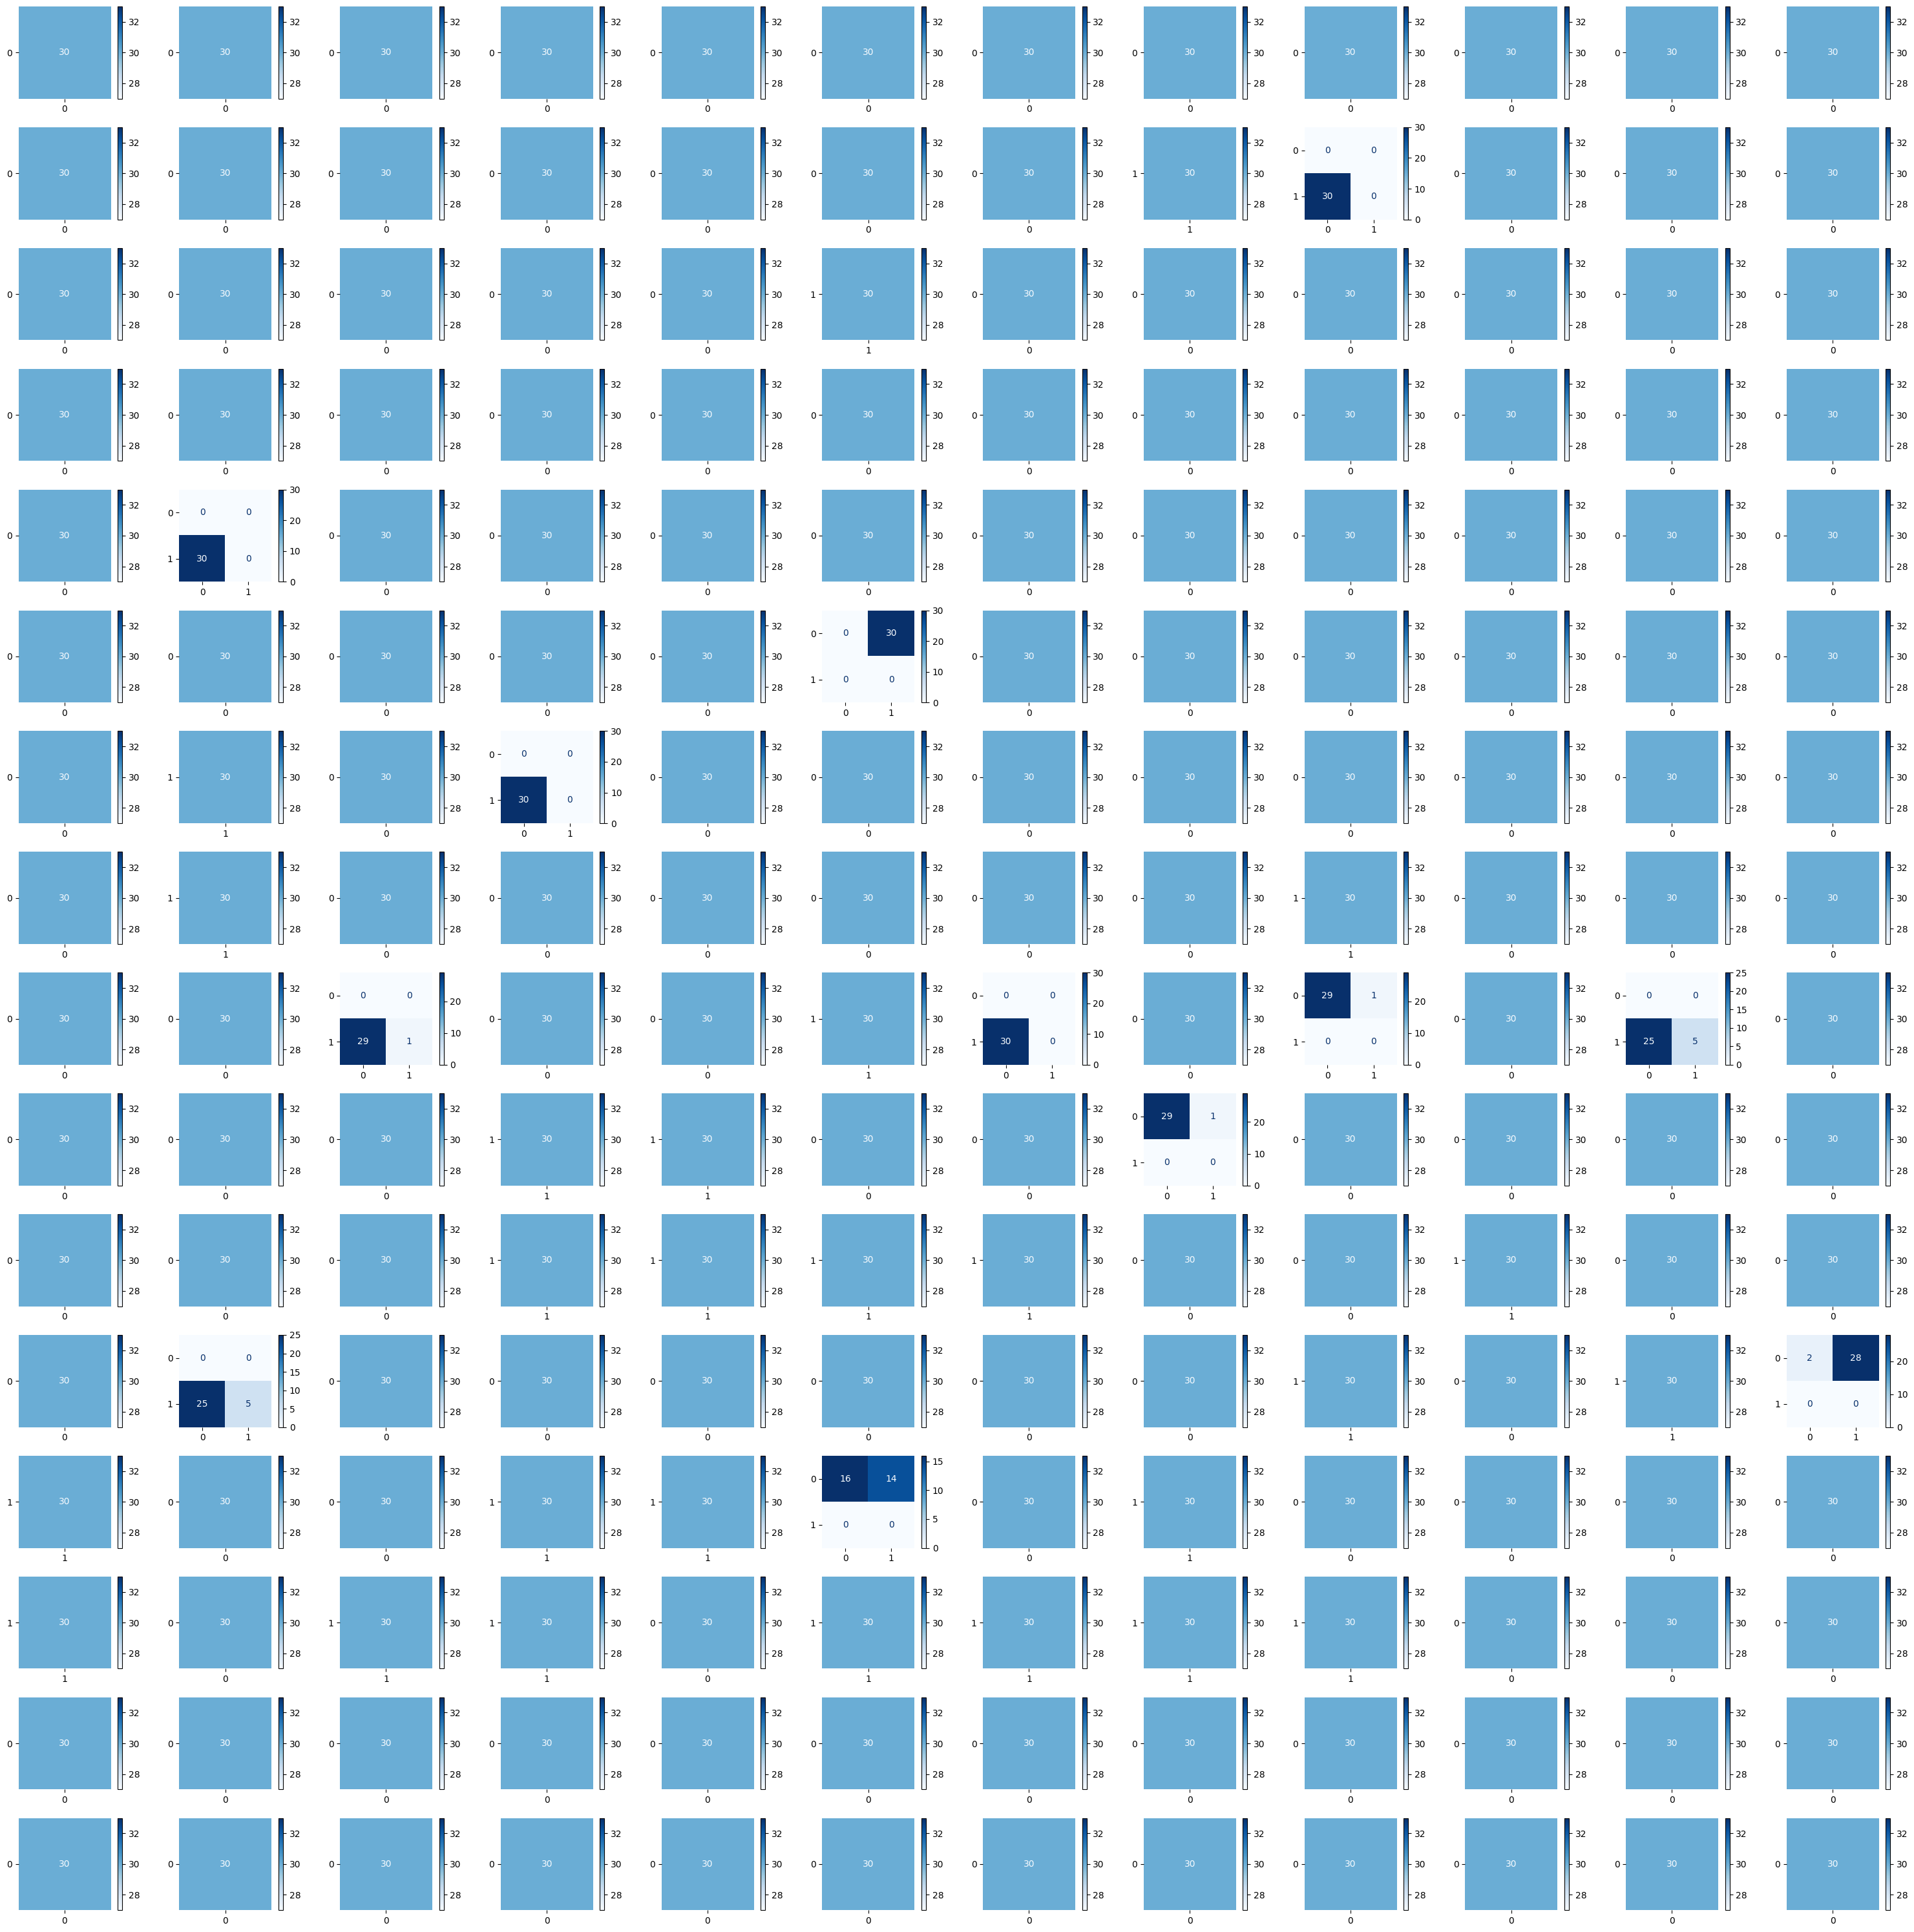

In [95]:
fig, axes = plt.subplots(nrows=16, ncols=12, figsize=(30, 30))

for y_t, y_p, cs, ax in tqdm(zip(y.T, y_pred.T, class_support, axes.flatten()), total=192):
    ConfusionMatrixDisplay.from_predictions(y_t, 
                        y_p, 
                        ax=ax, 
                        cmap='Blues',
                        )
    # remove x and y labels
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.grid(False)

    # outline
    strentgh = 1 - abs(cs - y.shape[0] / 2) / (y.shape[0] / 2) # higher strength for more balanced classes
    outline_color = (1, 0, 0, strentgh)

    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)

    ax.spines['top'].set_color(outline_color)
    ax.spines['right'].set_color(outline_color)
    ax.spines['bottom'].set_color(outline_color)
    ax.spines['left'].set_color(outline_color)

    ax.spines['top'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
print("Generated")
plt.tight_layout()
print("Layout ready")
plt.show()